###  Reuters corpus topic classification

This project is about topic classification on the Reuters corpus. It is multi-label classification: there can be more than one topics associated with each document.

#### Data

Test data will be extracted from XML-documents, taking input from <headline></headline> and <text></text>, target classes from <codes class = 'bip:topics:1.0'><code code = "topic_i"></code></codes>

input: 'document text string, each row a document'
target: ['topic_1', '...', 'topic_n'] = [0, ...., 1, 0]


There are 126 topics that are listed in the topic_codes.txt.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import *
from sklearn.model_selection import train_test_split

/home/hdheli/anaconda3/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [4]:
topics = pd.read_csv('mock-data/topic_codes.txt', delimiter='\t')
topics

,CODE,DESCRIPTION
0,1POL,CURRENT NEWS - POLITICS
1,2ECO,CURRENT NEWS - ECONOMICS
2,3SPO,CURRENT NEWS - SPORT
3,4GEN,CURRENT NEWS - GENERAL
4,6INS,CURRENT NEWS - INSURANCE
...,...,...
121,M142,METALS TRADING
122,M143,ENERGY MARKETS
123,MCAT,MARKETS
124,MEUR,EURO CURRENCY


In [15]:
codes = topics['CODE']
codes

0       1POL
1       2ECO
2       3SPO
3       4GEN
4       6INS
       ...  
121     M142
122     M143
123     MCAT
124     MEUR
125    PRB13
Name: CODE, Length: 126, dtype: object

### Exploring code combination distribution

Now there is the actual data in a csv file, let's do some analysis on it.

Five of the code combinations are quite common, there are 20 000 -10 000 examples for them.

Half of the combinations however have only one example.


In [12]:
trunc_large_data_strings = pd.read_csv('reuters-csv/inputs_trunc.csv', delimiter=';')

In [140]:
trunc_large_data_strings.describe

<bound method NDFrame.describe of                                                      text  \
0       Official Journal contents - OJ C 169 of June 4...   
1       Official Journal contents - OJ L 144 of June 4...   
2       Suncor lowers Canada heavy oil price. COMPANY ...   
3       Suncor cuts Canada light oil prices. COMPANY E...   
4       Toronto stocks end softer, more consolidation ...   
...                                                   ...   
299768  Reuters French Advertising & Media Digest -Jul...   
299769  Fleming issues buy recommendation on M6. Flemi...   
299770  China to launch Internet service for science d...   
299771  Reuters German Advertising & Media Digest -Jul...   
299772  Singapore Internet gets boost from television ...   

                                                   target  \
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [7]:
code_freqs = trunc_large_data_strings['codes'].value_counts()
code_freqs

['C15', 'C151', 'CCAT']                                            22203
['C15', 'C152', 'CCAT']                                            19751
['M11', 'MCAT']                                                    15791
['M14', 'M141', 'MCAT']                                            14675
['GCAT', 'GSPO']                                                   12390
                                                                   ...  
['C14', 'C18', 'C181', 'C183', 'CCAT']                                 1
['C11', 'C12', 'C33', 'CCAT', 'GCAT', 'GCRIM']                         1
['C13', 'CCAT', 'E51', 'E512', 'ECAT', 'GCAT', 'GENT']                 1
['C12', 'CCAT', 'E51', 'E512', 'ECAT', 'GCAT', 'GCRIM', 'GDIP']        1
['C18', 'C183', 'CCAT', 'E12', 'E21', 'ECAT']                          1
Name: codes, Length: 8326, dtype: int64

In [146]:
# these are more frecuent
code_freq_df = code_freqs.to_frame()
code_freq_df

,codes
"['C15', 'C151', 'CCAT']",22203
"['C15', 'C152', 'CCAT']",19751
"['M11', 'MCAT']",15791
"['M14', 'M141', 'MCAT']",14675
"['GCAT', 'GSPO']",12390
...,...
"['C12', 'C13', 'CCAT', 'GCAT', 'GCRIM', 'GENV', 'GPOL']",1
"['C13', 'CCAT', 'E12', 'ECAT', 'GCAT', 'GODD']",1
"['C13', 'C17', 'C171', 'C18', 'C183', 'C34', 'CCAT']",1
"['C15', 'C152', 'C31', 'CCAT', 'GCAT', 'GENT']",1


In [147]:
frequent_combos = code_freq_df[code_freq_df['codes']>10000]
frequent_combos

,codes
"['C15', 'C151', 'CCAT']",22203
"['C15', 'C152', 'CCAT']",19751
"['M11', 'MCAT']",15791
"['M14', 'M141', 'MCAT']",14675
"['GCAT', 'GSPO']",12390


In [148]:
rare_combos = code_freq_df[code_freq_df['codes']<10]
rare_combos

,codes
"['C13', 'C17', 'C173', 'CCAT']",9
"['M11', 'M13', 'M131', 'M132', 'MCAT']",9
"['E41', 'ECAT', 'GCAT', 'GCRIM', 'GJOB', 'GPOL']",9
"['GCAT', 'GFAS', 'GOBIT', 'GPRO']",9
"['C11', 'C18', 'C181', 'C182', 'CCAT']",9
...,...
"['C12', 'C13', 'CCAT', 'GCAT', 'GCRIM', 'GENV', 'GPOL']",1
"['C13', 'CCAT', 'E12', 'ECAT', 'GCAT', 'GODD']",1
"['C13', 'C17', 'C171', 'C18', 'C183', 'C34', 'CCAT']",1
"['C15', 'C152', 'C31', 'CCAT', 'GCAT', 'GENT']",1


In [150]:
code_freq_df[code_freq_df['codes']==1]

,codes
"['E12', 'GPOL', 'GVOTE', 'M132']",1
"['C11', 'C15', 'C152', 'C17', 'C171', 'C41', 'C411', 'CCAT']",1
"['C24', 'CCAT', 'GCAT', 'GDEF', 'GSCI']",1
"['C13', 'C15', 'CCAT', 'G15', 'G152', 'GCAT']",1
"['C11', 'C13', 'C18', 'C181', 'C34', 'CCAT', 'G15', 'G152', 'G157', 'GCAT']",1
...,...
"['C12', 'C13', 'CCAT', 'GCAT', 'GCRIM', 'GENV', 'GPOL']",1
"['C13', 'CCAT', 'E12', 'ECAT', 'GCAT', 'GODD']",1
"['C13', 'C17', 'C171', 'C18', 'C183', 'C34', 'CCAT']",1
"['C15', 'C152', 'C31', 'CCAT', 'GCAT', 'GENT']",1


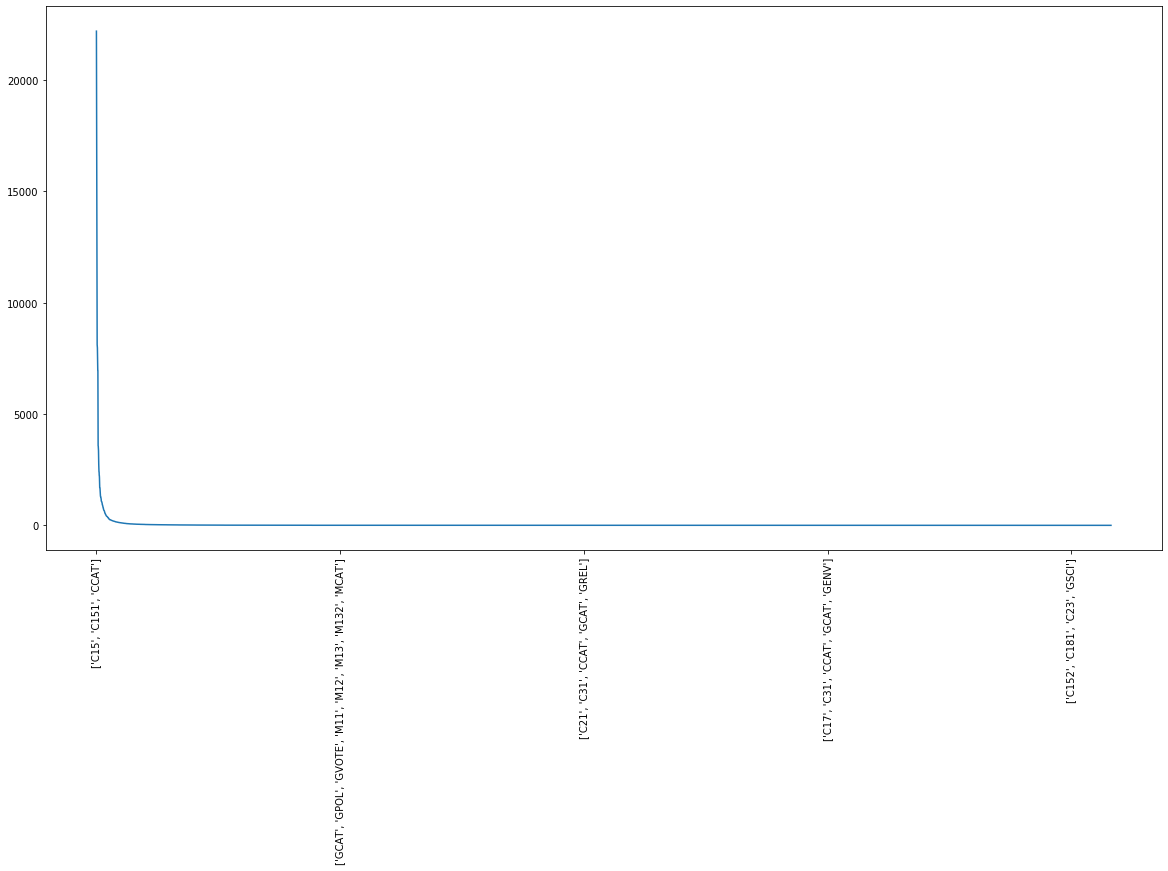

In [8]:
code_freqs.plot(figsize=(20,10), rot=90)

In [9]:
#  because of the target and codes are stored as strings and not as list, I will convert them back to lists
trunc_large_data = trunc_large_data_strings.copy(deep=True)
trunc_large_data['target'] = trunc_large_data['target'].apply(eval)
trunc_large_data['codes'] = trunc_large_data['codes'].apply(eval)

In [162]:
trunc_large_data['codes']

0               [G15, GCAT]
1               [G15, GCAT]
2         [M14, M143, MCAT]
3         [M14, M143, MCAT]
4               [M11, MCAT]
                ...        
299768          [C32, CCAT]
299769               [C152]
299770         [GCAT, GSCI]
299771          [C32, CCAT]
299772          [C22, CCAT]
Name: codes, Length: 299773, dtype: object

In [15]:
# function to explore the amounts of single codes, return a sorted dictionary

def code_amount_check(data):
    codes_amount_dict = {}
    for index, code_list in data['codes'].iteritems():
        for code in code_list:
            if codes_amount_dict.get(code) == None:
                codes_amount_dict[code] = 1
            else: 
                codes_amount_dict[code] += 1
                
    sorted_code_amounts = dict(sorted(codes_amount_dict.items(), key=lambda item: item[1]))            
    return sorted_code_amounts          

In [173]:
large_trunc_codes_amount_dict = code_amount_check(trunc_large_data)
large_trunc_codes_amount_dict

{'GMIL': 4,
 'G159': 8,
 'E312': 19,
 'E313': 38,
 'G156': 55,
 'E142': 70,
 'E61': 122,
 'GFAS': 141,
 'E141': 162,
 'GTOUR': 187,
 'GOBIT': 301,
 'E132': 348,
 'C313': 381,
 'C331': 401,
 'E143': 432,
 'C16': 591,
 'E311': 619,
 'GWELF': 664,
 'G152': 671,
 'G155': 704,
 'E121': 747,
 'E411': 760,
 'G153': 761,
 'E14': 778,
 'G157': 801,
 'E31': 857,
 'C32': 919,
 'E511': 949,
 'C23': 958,
 'GODD': 975,
 'GSCI': 989,
 'GREL': 989,
 'E513': 1019,
 'C173': 1043,
 'G151': 1101,
 'GENT': 1310,
 'C174': 1358,
 'C311': 1423,
 'G158': 1479,
 'GPRO': 1560,
 'C182': 1658,
 'GWEA': 1675,
 'C34': 1843,
 'C22': 1890,
 'E71': 1892,
 'E131': 2011,
 'GHEA': 2111,
 'C312': 2153,
 'E13': 2280,
 'GENV': 2429,
 'C183': 2708,
 'C14': 2770,
 'E11': 2971,
 'G154': 3177,
 'GDEF': 3245,
 'GDIS': 3393,
 'C411': 3682,
 'C42': 3794,
 'C41': 4089,
 'GVOTE': 4222,
 'E512': 4251,
 'C172': 4254,
 'C12': 4693,
 'M142': 4996,
 'C33': 5383,
 'E41': 5693,
 'GJOB': 5759,
 'E211': 6244,
 'C171': 6565,
 'G15': 6731,
 'E5

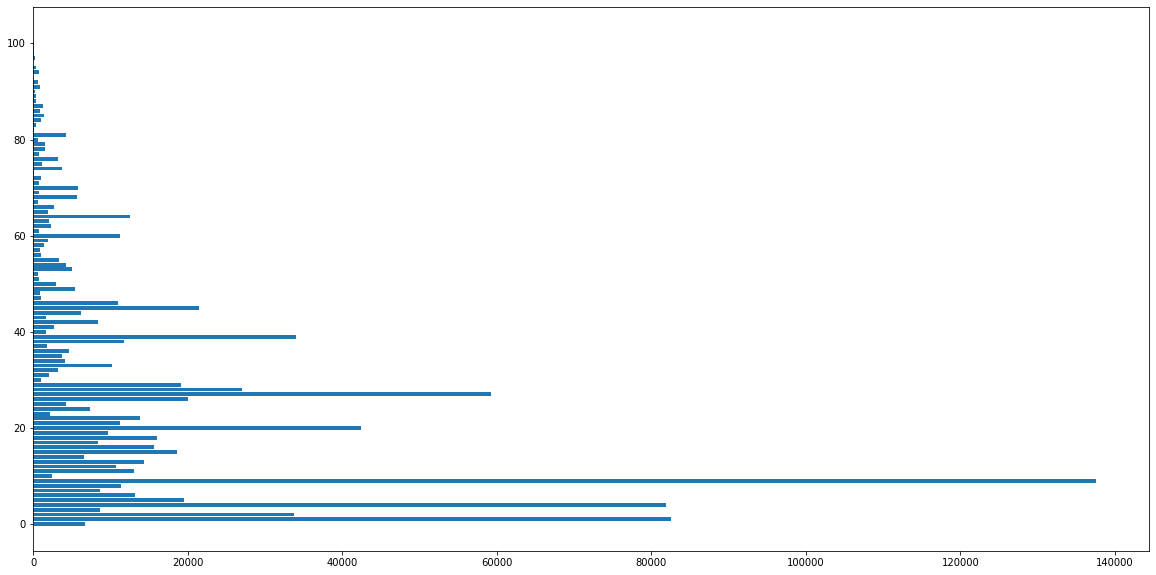

In [171]:
plt.barh(range(len(codes_amount_dict)), codes_amount_dict.values())
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

### Trying out transformer and BERT

Next I will be trying out things presented in a blog post: [Transformers for Multi-Label Classification made simple.](https://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1)

I will also utilize some code from the home exercises of Deep Learning course.

#### Data splits and dataloaders

Let's split the data and make iterators for batch training.

In [11]:
# data to lists

documents = list(trunc_large_data.text.values)
labels = list(trunc_large_data.target.values)

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

# encodings

encodings = tokenizer.batch_encode_plus(documents, padding='max_length', truncation=True) # tokenizer's encoding method
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

NameError: name 'documents' is not defined

In [13]:
# take rows that have too rare targets

label_counts = trunc_large_data.target.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(trunc_large_data[trunc_large_data.target.astype(str).isin(one_freq)].index), reverse=True)
#print('df label indices with only one instance: ', one_freq_idxs)

In [30]:
len(one_freq_idxs)

4596

In [31]:
# Gathering single instance inputs
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

In [32]:
len(input_ids)

295177

The original data is 299773 rows long, and 295177 when the unique target occurances have been separated. I will take 5 % split of these rows to mini train, and split dev and test from the remained part

In [36]:
remaining_inputs, mini_train_inputs, remaining_labels, mini_train_labels, remaining_token_types, mini_train_token_types, remaining_masks, mini_train_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                                                            random_state=42, test_size=0.05, stratify = labels)

In [39]:
print('remaining: ', len(remaining_inputs), 'mini-train: ', len(mini_train_inputs))

remaining:  280418 mini-train:  14759


In [40]:
# splitting the dataset further, now getting the dev mini set

remaining_inputs2, mini_dev_inputs, remaining_labels2, mini_dev_labels, remaining_token_types2, mini_dev_token_types, remaining_masks2, mini_dev_masks = train_test_split(remaining_inputs, remaining_labels, remaining_token_types, remaining_masks,
                                                            random_state=42, test_size=0.05, stratify = remaining_labels)

In [41]:
print('remaining2: ', len(remaining_inputs2), 'mini-dev: ', len(mini_dev_inputs))

remaining2:  266397 mini-dev:  14021


In [43]:
# and then splitting the test set

remaining_inputs3, mini_test_inputs, remaining_labels3, mini_test_labels, remaining_token_types3, mini_test_token_types, remaining_masks3, mini_test_masks = train_test_split(remaining_inputs2, remaining_labels2, remaining_token_types2, remaining_masks2,
                                                            random_state=42, test_size=0.05, stratify = remaining_labels2)


I will initially include all the 4596 one_freq rows in the mini_train_data, this can be changed later

In [44]:
mini_train_inputs.extend(one_freq_input_ids)
mini_train_labels.extend(one_freq_labels)
mini_train_masks.extend(one_freq_attention_masks)
mini_train_token_types.extend(one_freq_token_types)

In [45]:
# change mini train sets to tensors

t_mini_train_inputs = torch.tensor(mini_train_inputs)
t_mini_train_labels = torch.tensor(mini_train_labels)
t_mini_train_masks = torch.tensor(mini_train_masks)
t_mini_train_token_types = torch.tensor(mini_train_token_types)

In [49]:
# change mini dev sets to tensors

t_mini_dev_inputs = torch.tensor(mini_dev_inputs)
t_mini_dev_labels = torch.tensor(mini_dev_labels)
t_mini_dev_masks = torch.tensor(mini_dev_masks)
t_mini_dev_token_types = torch.tensor(mini_dev_token_types)

In [50]:
# change mini test sets to tensors

t_mini_test_inputs = torch.tensor(mini_test_inputs)
t_mini_test_labels = torch.tensor(mini_test_labels)
t_mini_test_masks = torch.tensor(mini_test_masks)
t_mini_test_token_types = torch.tensor(mini_test_token_types)

In [46]:
print(t_mini_train_inputs.shape)
print(t_mini_train_labels.shape)
print(t_mini_train_masks.shape)
print(t_mini_train_token_types.shape)

torch.Size([19355, 256])
torch.Size([19355, 126])
torch.Size([19355, 256])
torch.Size([19355, 256])


In [47]:
# create train iterator with torch dataloader

batch_size = 48

mini_train_data = TensorDataset(t_mini_train_inputs, t_mini_train_masks, t_mini_train_labels, t_mini_train_token_types)
mini_train_sampler = RandomSampler(mini_train_data)
mini_train_dataloader = DataLoader(mini_train_data, sampler=mini_train_sampler, batch_size=batch_size)


In [52]:
# create dev iterator with torch dataloader

from torch.utils.data import SequentialSampler

mini_dev_data = TensorDataset(t_mini_dev_inputs, t_mini_dev_masks, t_mini_dev_labels, t_mini_dev_token_types)
mini_dev_sampler = SequentialSampler(mini_dev_data)
mini_dev_dataloader = DataLoader(mini_dev_data, sampler=mini_dev_sampler, batch_size=batch_size)

In [53]:
# create test iterator with torch dataloader

mini_test_data = TensorDataset(t_mini_test_inputs, t_mini_test_masks, t_mini_test_labels, t_mini_test_token_types)
mini_test_sampler = SequentialSampler(mini_test_data)
mini_test_dataloader = DataLoader(mini_test_data, sampler=mini_test_sampler, batch_size=batch_size)

In [54]:
# save (file sizes are around 95-140 MB for mini loaders, so these are gitignored)

torch.save(mini_train_dataloader,'data-loaders/mini-train_data_loader')
torch.save(mini_dev_dataloader,'data-loaders/mini-dev_data_loader')
torch.save(mini_test_dataloader,'data-loaders/mini-test_data_loader')

### Shortcut

If there is a saved dataloader, this can be the startpoint

In [4]:
loaded_mini_train_dataloader = torch.load('data-loaders/mini-train_data_loader')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/hdheli/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### Model loading, initial optimizer and criterion

The huggingface transformers have AdamW that has gradient bias correction and weight decay. The optimizer hyperparemeters can be [customised](https://huggingface.co/transformers/training.html), but I start simple with the default settings.

In [7]:
# Model 1

NUM_LABELS = 126 # amount of the different topics
ADAM_DEFAULT_LR = 1e-5

model_1 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS)
model_1.to(device)

optimizer_1 = AdamW(model_1.parameters(), lr=ADAM_DEFAULT_LR)
criterion_1 = BCEWithLogitsLoss() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
# Utility

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [9]:
# --- Train Loop ---

import time

def train_loop(model, model_name, optimizer, criterion, n_epochs, dataloader):
    train_losses = []
    model.train()
    step = 0
    examples = 0
    
    for epoch in range(n_epochs):
        start_time = time.time()
        epoch_loss = 0
        for step, batch in enumerate(dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels, b_token_types = batch # unpack from dataloader
            print('unloaded dim', b_input_ids.shape, b_input_mask.shape, b_labels.shape, b_token_types.shape)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs[0]
            print('logits', logits)
            loss = criterion(logits.view(-1, NUM_LABELS),b_labels.type_as(logits).view(-1,NUM_LABELS)) #convert labels to float for calculation
            
            # Backward pass
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            examples += b_input_ids.size(0)
            steps += 1
            
        train_loss = epoch_loss / len(dataloader)
        train_losses.append(train_loss)
            
        end_time = time.time()
            
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        torch.save(model.state_dict(), model_name)
            
    return model, train_losses

In [10]:
# train model 1, just one epoch to test

n_epochs_1 = 1

trained_model_1, train_losses = train_loop(model_1, 'models/model_1_260321', optimizer_1, criterion_1, n_epochs_1, loaded_mini_train_dataloader)


unloaded dim torch.Size([48, 256]) torch.Size([48, 256]) torch.Size([48, 126]) torch.Size([48, 256])
logits tensor([[-0.3708,  0.3800, -0.3711,  ..., -0.2434,  0.3016,  0.4135],
        [-0.1564,  0.4655, -0.4990,  ..., -0.2637, -0.2344,  0.2109],
        [-0.3535,  0.5852, -0.7945,  ...,  0.1883, -0.0653,  0.4057],
        ...,
        [-0.0694,  0.0340, -0.3414,  ..., -0.1565,  0.2508,  0.0862],
        [-0.2443,  0.3665, -0.6011,  ..., -0.0867, -0.0059,  0.3010],
        [-0.2932,  0.5382, -0.7429,  ...,  0.0548,  0.1851,  0.1194]],
       grad_fn=<AddmmBackward>)


KeyboardInterrupt: 